## Imports

In [1]:
import networkx as nx
import random
from sklearn import metrics
from cdlib import algorithms
from cdlib import evaluation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import stats
import os
from tqdm import tqdm as tqdm
import pickle

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'leidenalg', 'karateclub', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


## Classification Functions

In [2]:
#function to create duplex network of the required format from two graph objects
def duplex_network (G, l1, l2):
    #create copies of the input graphs
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    
    #delete common edges in layer 1
    list_of_common_edges = []
    
    for e in G[l1].edges():
        if G[l2].has_edge(e[0], e[1]):
            list_of_common_edges.append([e[0], e[1]])
            
    
    print (len(list_of_common_edges))
    
    #delete common edges in layer 1
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])
        
    
    
    #delete nodes with zero degree
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.remove_node(n)
        
    list_of_nodes = []
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G2.remove_node(n)
            
    

    ##create union of nodes
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
        
        
        

    return G1, G2


#######

# create instances of partial information from the fromatted graph objects
def partial_information (G1, G2, frac):
    
    
    
    ##create training/test sets
    Etest = {}
    Etrain = {}
    #choose edges randomly
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0
        
        
    
    #create remnants edge sets based on test and train sets
    rem_G1 = nx.Graph()
    rem_G2 = nx.Graph()
    for n in G1:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
    for n in G2:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
        
        
    #create output list of test edges
    for e in Etest:
        rem_G1.add_edge(e[0], e[1])
        rem_G2.add_edge(e[0], e[1])
            
    
    for e in Etrain:
        if Etrain[e] == 1:
            rem_G1.add_edge(e[0], e[1])
        if Etrain[e] == 0:
            rem_G2.add_edge(e[0], e[1])
    
    
    return rem_G1, rem_G2, Etest 


#####








#function to find communities from the remnant graphs
def community_finder (G):
    #use Louvain algorithm to find communities
    C = algorithms.louvain(G)
    sigma = {}
    c = 0
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1
    # calculate community strength mu
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
            
        
    return sigma, mu, tot



#partial information based classifier use TT=0 for degree and community- based classification, TT=1 for degree-basde and TT=2 for community based classification

def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False):
    
    ## degree and community 
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        #compute universal mu
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)


        #start generating probabilties for test set
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
                
            n = e[0]
            m = e[1]
            #probabilities
            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            #if equal probabilties: classify randomly 
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
            #print some information     
            if show_log == True: 
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')
                
                
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
    
        return classification, scores, ground_truth
    
    
    ## degree based classification
    if TT == 1:
        
        classification, scores, ground_truth = [], [], []
        #start generating probabilties for test set
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)    
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            #if equal probabilities; classify randomly
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                   
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
        return classification, scores, ground_truth
    
        
        
        
    ## community
    if TT == 2:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        #compute total mu
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)
        
        
        classification, scores, ground_truth = [], [], []
        #start generating probabilities for the test set
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = 1.0
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = 1.0
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            #if equal probabilities; classify randomly
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
        
        
    
####

#function to perform complete analysis shown in the paper using all of the functions above
def perform_analysis (G1, G2, step, TT = 0):
    #x:fractional information, y: accuracy, z:aucroc
    x , y, z  = [], [], []
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
    #perform analysis for the network
    #generate remnant sets and partial information
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
    #make classification
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)
    #compute accuracy
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
    #collect results
            x.append(frac)
            y.append(acc)
            z.append(auc)
    #increment the amount of partial information
        frac += step
    #compile results
    results = [x, y, z]
    return results



## Synthetic Network Models

In [3]:
#function to generate power sequence
def generate_power_law (gamma, kmin, kmax):  
    xmin = np.power(kmin, 1.0 - gamma)
    xmax = np.power(kmax, 1.0 - gamma)
    x = xmax - random.random()*(xmax - xmin)
    x = np.power(x, 1.0 / (1.0 -gamma))
    return int(x)

#function to control the correlation between two degree sequences by shuffling
def control_correlation (degree, prob):
    #create new degree sequence
    tmp_degree = []
    #original sequence
    for i in range(len(degree)):
        tmp_degree.append(degree[i])
    #shuffled sequence
    for i in range(len(tmp_degree)):
        if random.random()<prob:
            n = tmp_degree[i]
            j = random.randint(0, len(degree)-1)
            tmp_degree[i] = tmp_degree[j]
            tmp_degree[j] = n
    return tmp_degree


#####

#function to create a network generated by the configuration model without self loops and multiedges
def generate_configuration_model (degree):
    
    edges = []
    for i in range(0, len(degree)):
        k = degree[i]
        for j in range(0, k):
            edges.append(i)
            
    ##random.shuffle(edges)
    for i in range(0, len(edges)):
        j = random.randint(0, len(edges)-1)
        tmp = edges[i]
        edges[i] = edges[j]
        edges[j] = tmp
    
    
    
    G = nx.Graph()
    for n in range(0, len(degree)):
        G.add_node(n)
        
    for i in range(0, len(edges)-1, 2):
        n = edges[i]
        m = edges[i+1]
        if G.has_edge(n, m) == False:
            G.add_edge(n, m)
            
    return G
    

################
    
def generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign):
    
#     print ('# N = ', N)
#     print ('# gamma = ', gamma)
#     print ('# kmin = ', kmin)
#     print ('# kmax = ', kmax)
#     print ('# prob = ', prob)
#     print ('# sign = ' , sign)
    
    degree = []
    for i in range(0, N):
        degree.append(generate_power_law (gamma, kmin, kmax))
    degree = sorted(degree)
    tmp_degree = []
    for i in range (0, len(degree)):
        if sign > 0:
            tmp_degree.append(degree[i])
        if sign < 0:
            tmp_degree.append(degree[len(degree)-i-1])
            
    
    ###
    tmp_degree = control_correlation (tmp_degree, prob)
    ###
    
    G = {}
    G[1] = generate_configuration_model (degree)
    G[2] = generate_configuration_model (tmp_degree)
    
    
    ###
    
    return G
    
    
#########

In [4]:
#create LFR networks using the C file through Python
def LFR(n,t1,t2,mu,avg_k,max_k):
    #function to generate LFR network as a networkx object and obtain community assignments
    #write command to pass in the terminal
    N,Mu,T1,T2,maxk,k=str(n),str(mu),str(t1),str(t2),str(max_k),str(avg_k)
    s='./benchmark -N '+N+' -mu '+Mu+ ' -maxk ' +maxk  + ' -k '+k  +' -t1 ' +T1+' -t2 ' +T2
    os.system(s)
    #load the network from the file generated by the C program
    x=np.loadtxt('network.dat')
    edges=[(int(x[i][0])-1,int(x[i][1])-1) for i in range(len(x))]
    g=nx.Graph(edges)
    #load community strcuture information from the file generated by the C program
    x=np.loadtxt('community.dat')
    coms={int(x[i][0])-1:int(x[i][1]) for i in range(len(x))}
    
    return g, coms

#function to generate a duplex network with layers from the LFR model with the desired relabelling probability to control for community correlation
def lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel):
    #generate LFR networks with desired paramters
    H, comm = LFR(n=N, t1=tau1, t2=tau2, mu=mu, avg_k=average_degree, max_k = max_degree)  
    #get community structure information 
    groups = {}
    for n in comm:
        c = comm[n]
        if c not in groups:
            groups[c] = []
        groups[c].append(n)
        
   #############################   

    sigma1 = {}
    for n in comm:
        sigma1[n] = comm[n]

   #########
        
    #generate new labels based on required amount of shuffling
    new_labels = {}
    for C in groups:
        tmp = groups[C].copy()
        random.shuffle(tmp)
        for i in range(0, len(groups[C])):
            n = groups[C][i]
            m = tmp[i]
            new_labels[n] = m
    ###########################################  
    
    tmp_sigma2 = {}
    for n in sigma1:
        m = new_labels[n]
        tmp_sigma2[m] = sigma1[n]
        
    ###########################################
    
    
    
    #create graph objects
    G = {}
    G[1] = H.copy()
    G[2] = nx.Graph()
    for n in G[1]:
        G[2].add_node(n)
    for e in G[1].edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)
    ############################################
    
    
    
    
    
    #create layer 2
    #############################################
    ## break community correlation
    
    list_nodes = list(G[2].nodes())
    new_labels = {}
    H = G[2].copy()
    for n in G[2]:
        new_labels[n] = n
    for n in new_labels:
        if random.random()<prob_relabel:
            m = random.choice(list_nodes)
            tmp = new_labels[n]
            new_labels[n] = new_labels[m]
            new_labels[m] = tmp
            
    G[2] = nx.Graph()
    for n in H:
        m = new_labels[n]
        G[2].add_node(m)
    for e in H.edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)
    ##############################################
    
    
    sigma2 = {}
    for n in tmp_sigma2:
        m = new_labels[n]
        sigma2[m] = tmp_sigma2[n]
    
    
    
    return G, sigma1, sigma2, mu

## Figure 5a

In [9]:
#set desired paramters
N = 10000
tau2 = 1.0
gamma = 2.1
max_degree = int(np.sqrt(N))
min_community = 1
prob = 1.0
mu = 0.1
step = 0.1

results_lfr = {}

In [10]:
#generate network and get results
average_degree = 5.0

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[average_degree] = perform_analysis (G1, G2, step, TT=0)

12
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [11]:
#generate network and get results
average_degree = 10.0

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[average_degree] = perform_analysis (G1, G2, step, TT=0)

31
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [12]:
#generate network and get results
average_degree = 15.0

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[average_degree] = perform_analysis (G1, G2, step, TT=0)

121
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [13]:
#generate network and get results
average_degree = 20.0

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[average_degree] = perform_analysis (G1, G2, step, TT=0)

199
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [14]:
#generate network and get results
average_degree = 25.0

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[average_degree] = perform_analysis (G1, G2, step, TT=0)

326
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [15]:
#create pickle file
with open('figure5a_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
#load pickle file
with open('figure5a_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

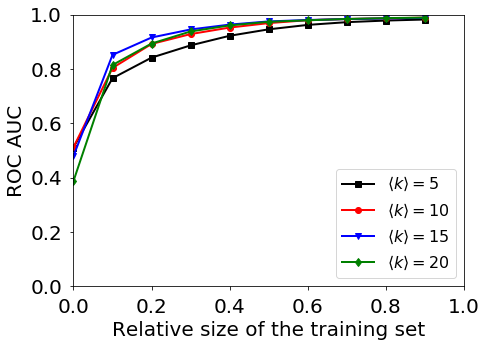

In [23]:
#generate plot used in paper
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

average_degree = 5.0
plt.plot(results_lfr[average_degree][0], results_lfr[average_degree][2], marker='s', linewidth=2, color = 'black', label='$\\langle k \\rangle = 5$')

average_degree = 10.0
plt.plot(results_lfr[average_degree][0], results_lfr[average_degree][2], marker='o', linewidth=2, color = 'red', label='$\\langle k \\rangle = 10$')


average_degree = 15.0
plt.plot(results_lfr[average_degree][0], results_lfr[average_degree][2], marker='v', linewidth=2, color = 'blue', label='$\\langle k \\rangle = 15$')


average_degree = 20.0
plt.plot(results_lfr[average_degree][0], results_lfr[average_degree][2], marker='d', linewidth=2, color = 'green', label='$\\langle k \\rangle = 20$')


# average_degree = 25.0
# plt.plot(results_lfr[average_degree][0], results_lfr[average_degree][2], marker='D', linewidth=2, color = 'orange', label='$\\langle k \\rangle = 25$')
         



plt.legend(loc='lower right', fontsize = 16)
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 5b

In [24]:
#set desired paramters
tau2 = 1.0
gamma = 2.1
min_community = 1
prob = 1.0
mu = 0.1
step = 0.1
average_degree = 5.0


results_lfr = {}

In [25]:
#create networks and perform analysis
N = 1000
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[N] = perform_analysis (G1, G2, step, TT=0)

11
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [26]:
#create networks and perform analysis
N = 2000
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[N] = perform_analysis (G1, G2, step, TT=0)

9
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [27]:
#create networks and perform analysis
N = 5000
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[N] = perform_analysis (G1, G2, step, TT=0)

14
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [28]:
#create networks and perform analysis
N = 10000
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[N] = perform_analysis (G1, G2, step, TT=0)

19
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [29]:
#save to pickle file
with open('figure5b_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
#load pickle file
with open('figure5b_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

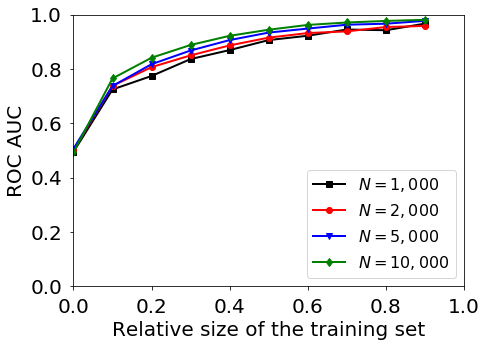

In [32]:
#generate plot used in the paper
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

N = 1000
plt.plot(results_lfr[N][0], results_lfr[N][2], marker='s', linewidth=2, color = 'black', label='$N = 1,000$')

N = 2000
plt.plot(results_lfr[N][0], results_lfr[N][2], marker='o', linewidth=2, color = 'red', label='$N = 2,000$')


N = 5000
plt.plot(results_lfr[N][0], results_lfr[N][2], marker='v', linewidth=2, color = 'blue', label='$N = 5,000$')


N = 10000
plt.plot(results_lfr[N][0], results_lfr[N][2], marker='d', linewidth=2, color = 'green', label='$N = 10,000$')




plt.legend(loc='lower right', fontsize = 16)
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 5c

In [33]:
#set desired paramters
kmin = 3
sign = 1
prob = 1.0
step = 0.1
gamma = 2.1

results = {}

In [34]:
#create networks and perform analysis
N = 1000
kmax = int(np.sqrt(N))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[N] = perform_analysis (G1, G2, step, TT=1)

22
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [35]:
#create networks and perform analysis
N = 10000
kmax = int(np.sqrt(N))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[N] = perform_analysis (G1, G2, step, TT=1)

49
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [36]:
#create networks and perform analysis
N = 100000
kmax = int(np.sqrt(N))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[N] = perform_analysis (G1, G2, step, TT=1)

91
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [38]:
# N = 1000000
# kmax = int(np.sqrt(N))
# G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
# l1 = 1
# l2 = 2
# G1, G2 = duplex_network (G, l1, l2)

# results[N] = perform_analysis (G1, G2, step, TT=1)

In [39]:
#save to pickle file
with open('figure5c_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
#load pickle file
with open('figure5c_data.pk', 'rb') as handle:
    results = pickle.load(handle)

(0.0, 1)

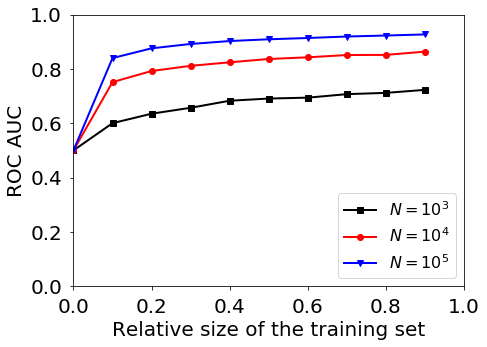

In [41]:
#generate plot used in the paper
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

N = 1000
plt.plot(results[N][0], results[N][2], marker='s', linewidth=2, color = 'black', label='$N = 10^3$')

N = 10000
plt.plot(results[N][0], results[N][2], marker='o', linewidth=2, color = 'red', label='$N = 10^4$')


N = 100000
plt.plot(results[N][0], results[N][2], marker='v', linewidth=2, color = 'blue', label='$N = 10^5$')


# N = 1000000
# plt.plot(results[N][0], results[N][2], marker='d', linewidth=2, color = 'green', label='$N = 10^6$')




plt.legend(loc='lower right', fontsize = 16)
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)